In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
import cv2
from pickle import dump, load
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,BatchNormalization
import pickle as pk
from tensorflow.keras import applications
import os
import numpy as np
import dlib

In [7]:
dlib.__version__

'19.24.0'

In [8]:
!python --version

Python 3.7.12


# Analyzing dataset

In [9]:
DATA_DIR = "/kaggle/input/pain-dataset-mini/pain dataset mini v3/pain dataset mini v3"

In [10]:
class_0_size = len(os.listdir(DATA_DIR+"/0"))
class_0_size

5070

In [11]:
class_1_size = len(os.listdir(DATA_DIR + "/1"))
class_1_size

4757

In [12]:
print("percentage of class 1 dataset : ", (class_1_size/ (class_0_size + class_1_size)) *100)
print("percentage of class 0 dataset : ", (class_0_size/ (class_0_size + class_1_size)) *100)

percentage of class 1 dataset :  48.40744886537092
percentage of class 0 dataset :  51.59255113462908


# Loading dataset

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from itertools import chain

In [14]:
# data_generator = ImageDataGenerator(
#     horizontal_flip=True,
#     rescale=1.1,
#     rotation_range= 10, #-10 degree - 10 degree
#     validation_split = 0.20
# )

data_generator = ImageDataGenerator(
    horizontal_flip=True,
    rescale=None,
    validation_split=0.3
)
batch_size = 64

In [15]:
train_generator = data_generator.flow_from_directory(
    directory= DATA_DIR,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",
    subset='training',
    shuffle=True,
    seed=42
)



validation_generator= data_generator.flow_from_directory(
    directory= DATA_DIR,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",
    subset='validation',
    shuffle=False,
    seed=42
)


Found 6879 images belonging to 2 classes.
Found 2948 images belonging to 2 classes.


In [16]:
train_generator.samples, validation_generator.samples

(6879, 2948)

In [17]:
for xb_train, yb_train in train_generator:
    print(xb_train.shape, yb_train.shape)
    print(yb_train[:10])
    break

(64, 128, 128, 3) (64,)
[1. 1. 0. 0. 1. 1. 1. 1. 0. 1.]


In [18]:
from sklearn.utils import class_weight
import numpy as np

In [19]:
np.unique(train_generator.classes)

array([0, 1], dtype=int32)

In [20]:
# class_weights = dict(zip(np.unique(train_generator.classes),class_weight.compute_class_weight(
#                         class_weight = 'balanced',
#                         classes = np.unique(train_generator.classes), 
#                         y = train_generator.classes)))
class_weights = {
    0 : 1,
    1: 2
}

In [21]:
# from collections import Counter

# counter = Counter(train_generator.classes)
# total = float(sum(counter.values()))
# class_weights = {class_id : (1/num_images)*(total)/2.0 for class_id, num_images in counter.items()}
# class_weights

In [22]:
def plot_history(hist):
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc='upper left')
    plt.show()

# Building Model

In [23]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPooling2D, BatchNormalization
from tensorflow.keras import applications
from tensorflow import keras
import tensorflow as tf

In [24]:
def Model_vgg(img_shape, fine_tune=0):
    pretrained_model = applications.vgg16.VGG16(weights='imagenet', include_top=False,input_shape=img_shape)
    model = Sequential()
    
    for layer in pretrained_model.layers:
        model.add(layer)
    
    # freezing vgg16 layers
    if fine_tune > 0:
        for layer in model.layers[:-fine_tune]:
            layer.trainable = False
    elif fine_tune == 'all':
        pass
    else:
        for layer in model.layers:
            layer.trainable = False
    # building dense layer
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.8))
#     model.add(Dense(500, activation='relu'))
#     model.add(Dropout(0.6))
#     model.add(Dense(50, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

# Creating logs and checkpoints

In [25]:
# creating logs
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


LOG_NAME = "logs/vgg16_1"
# !mkdir "logs/"
tensorboard = TensorBoard(log_dir=LOG_NAME)

# checkpoints
CHECKPOINT_NAME = "checkpoints/checkpoint_e{epoch:02d}_Va{val_accuracy:.02f}.h5"
checkpoint = ModelCheckpoint(CHECKPOINT_NAME, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                            mode='max')

2022-12-14 08:47:12.156653: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-14 08:47:12.156699: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-14 08:47:12.262172: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-12-14 08:47:12.302505: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-14 08:47:12.302656: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


# Model Training 

In [26]:
model = Model_vgg((128, 128, 3))

2022-12-14 08:47:12.459787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 08:47:12.460786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 08:47:12.523040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 08:47:12.523965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 08:47:12.524824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

58900480/58889256 [==============================] - 0s 0us/step


In [27]:
hist = model.fit(train_generator,
                steps_per_epoch = train_generator.samples // batch_size,
                validation_data = validation_generator, 
                validation_steps = validation_generator.samples // batch_size,
                verbose = 1,
                epochs = 5,
                callbacks=[tensorboard, checkpoint],
                class_weight=class_weights)

2022-12-14 08:47:17.147510: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-12-14 08:47:19.845742: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/107 [..............................] - ETA: 23:41 - loss: 1.2691 - accuracy: 0.6094

2022-12-14 08:47:30.642661: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-14 08:47:30.642707: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/107 [..............................] - ETA: 1:38 - loss: 1.4436 - accuracy: 0.5703 

2022-12-14 08:47:31.555814: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-14 08:47:31.556237: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-14 08:47:31.723566: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 186 callback api events and 183 activity events. 
2022-12-14 08:47:31.732856: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-14 08:47:31.750981: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_14_08_47_31

2022-12-14 08:47:31.755622: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_14_08_47_31/8def7c0fa80b.trace.json.gz


  4/107 [>.............................] - ETA: 45s - loss: 1.5214 - accuracy: 0.5312 

2022-12-14 08:47:31.779237: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_14_08_47_31

2022-12-14 08:47:31.781562: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_14_08_47_31/8def7c0fa80b.memory_profile.json.gz
2022-12-14 08:47:31.782246: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_14_08_47_31
Dumped tool data for xplane.pb to logs/vgg16_1/train/plugins/profile/2022_12_14_08_47_31/8def7c0fa80b.xplane.pb
Dumped tool data for overview_page.pb to logs/vgg16_1/train/plugins/profile/2022_12_14_08_47_31/8def7c0fa80b.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/vgg16_1/train/plugins/profile/2022_12_14_08_47_31/8def7c0fa80b.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/vgg16_1/train/plugins/pr

107/107 [==============================] - 66s 497ms/step - loss: 0.8892 - accuracy: 0.7290 - val_loss: 0.1558 - val_accuracy: 0.9582

Epoch 00001: val_accuracy improved from -inf to 0.95822, saving model to checkpoints/checkpoint_e01_Va0.96.h5
Epoch 2/5
107/107 [==============================] - 16s 150ms/step - loss: 0.3882 - accuracy: 0.8836 - val_loss: 0.1205 - val_accuracy: 0.9616

Epoch 00002: val_accuracy improved from 0.95822 to 0.96162, saving model to checkpoints/checkpoint_e02_Va0.96.h5
Epoch 3/5
107/107 [==============================] - 16s 147ms/step - loss: 0.2678 - accuracy: 0.9200 - val_loss: 0.0987 - val_accuracy: 0.9715

Epoch 00003: val_accuracy improved from 0.96162 to 0.97147, saving model to checkpoints/checkpoint_e03_Va0.97.h5
Epoch 4/5
107/107 [==============================] - 16s 145ms/step - loss: 0.2097 - accuracy: 0.9384 - val_loss: 0.0891 - val_accuracy: 0.9759

Epoch 00004: val_accuracy improved from 0.97147 to 0.97588, saving model to checkpoints/checkp

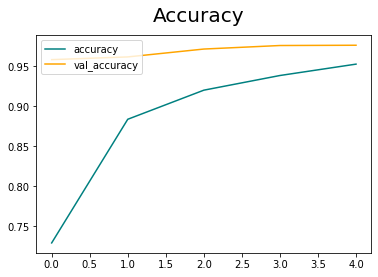

<Figure size 432x288 with 0 Axes>

In [35]:
plot_history(hist)
plt.savefig("training vs testing accuracy")

In [29]:
evalu = model.evaluate(validation_generator)
print(model.metrics_names)
print(evalu)

47/47 [==============================] - 6s 115ms/step - loss: 0.0875 - accuracy: 0.9763
['loss', 'accuracy']
[0.08753444254398346, 0.9762550592422485]


In [ ]:
# hist = model.fit(train_generator,
#                 steps_per_epoch = train_generator.samples // batch_size + 1,
#                 validation_data = validation_generator, 
#                 validation_steps = validation_generator.samples // batch_size + 1, 
#                 verbose = 1,
#                 epochs = 10,
#                 callbacks=[tensorboard, checkpoint],
#                 class_weight=class_weights)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

In [31]:
Y_pred = model.predict_generator(validation_generator, validation_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix: ')
confusion_matrix_ = confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix_)

print('Classification Report')
target_names = ['0', '1']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix: 
[[1464   57]
 [  14 1413]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1521
           1       0.96      0.99      0.98      1427

    accuracy                           0.98      2948
   macro avg       0.98      0.98      0.98      2948
weighted avg       0.98      0.98      0.98      2948



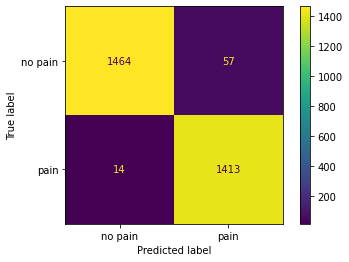

<Figure size 432x288 with 0 Axes>

In [34]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ['no pain', 'pain'])
cm_display.plot()
plt.show()
plt.savefig("confusion matrix")

In [33]:
model.save("model_accuracy_98.h5")

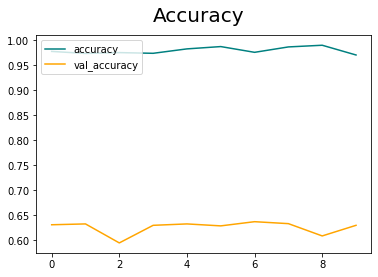

In [47]:
plot_history(hist)

In [45]:
-
!zip -r file_checkpoints.zip /kaggle/working/checkpoints 

  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/checkpoint_e01_Va0.63.h5 (deflated 7%)
  adding: kaggle/working/checkpoints/checkpoint_e02_Va0.64.h5 (deflated 7%)
  adding: kaggle/working/checkpoints/checkpoint_e05_Va0.65.h5 (deflated 7%)


In [41]:
model.save("model_val_acc_90.h5")

# Model prediction

In [37]:
def predict(image):
    IMG_SHAPE = 128
    
    # detect face in the image
    face_detector = dlib.cnn_face_detection_model_v1("/kaggle/input/models/mmod_human_face_detector.dat")
    faces = face_detector(image, 0)
                
    if not len(faces):
        c += 1
        print("no face detected..")
        return -1
                    
    face = faces[0]
    x = face.rect.left()
    y = face.rect.top()
    x1 = face.rect.right()
    y1 = face.rect.bottom()

    face_cropped = image[y: y1, x: x1]
    img_data = cv2.resize(face_cropped, (IMG_SHAPE, IMG_SHAPE))
    return np.argmax(model.predict(img_data.reshape(-1, IMG_SHAPE, IMG_SHAPE, 3)), axis=1)

In [38]:
!wget "https://cdn2.psychologytoday.com/assets/styles/manual_crop_1_91_1_1528x800/public/2018-12/shutterstock_194688362.jpg?itok=PWu8T3PY"

--2022-12-14 05:38:13--  https://cdn2.psychologytoday.com/assets/styles/manual_crop_1_91_1_1528x800/public/2018-12/shutterstock_194688362.jpg?itok=PWu8T3PY
Resolving cdn2.psychologytoday.com (cdn2.psychologytoday.com)... 216.137.45.75, 216.137.45.59, 216.137.45.49, ...
Connecting to cdn2.psychologytoday.com (cdn2.psychologytoday.com)|216.137.45.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83537 (82K) [image/jpeg]
Saving to: ‘shutterstock_194688362.jpg?itok=PWu8T3PY’

shutterstock_194688 100%[===================>]  81.58K  --.-KB/s    in 0.03s   

2022-12-14 05:38:13 (2.50 MB/s) - ‘shutterstock_194688362.jpg?itok=PWu8T3PY’ saved [83537/83537]



In [39]:
image = cv2.imread("/kaggle/working/shutterstock_194688362.jpg?itok=PWu8T3PY")
predict(image)

array([0])

In [1]:
!zip mmod_.zip /kaggle/input/models/mmod_human_face_detector.dat

  adding: kaggle/input/models/mmod_human_face_detector.dat (deflated 7%)


# Model tunning

In [93]:
model.trainable  = True
assert model.layers[0].trainable == True
model.layers[0]

In [90]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.optimizer = opt

In [92]:
hist = model.fit(train_generator,
                steps_per_epoch = train_generator.samples // batch_size + 1,
                validation_data = validation_generator, 
                validation_steps = validation_generator.samples // batch_size + 1, 
                verbose = 1,
                epochs = 10,
                callbacks=[tensorboard, checkpoint],
                class_weight=class_weights)

Epoch 1/10


FailedPreconditionError:  Could not find variable _AnonymousVar637. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status=Not found: Resource localhost/_AnonymousVar637/N10tensorflow3VarE does not exist.
	 [[node Adam/Cast/ReadVariableOp (defined at tmp/ipykernel_23/4217061190.py:8) ]] [Op:__inference_train_function_42846]

Function call stack:
train_function
